# Missing Value Imputation and Principal Component Analysis

## Multivariate Imputation

In [61]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA, KernelPCA

sns.set_theme()

In [52]:
# import data from csv
df = pd.read_csv('data/missing-values.csv', encoding='unicode_escape').drop('Unnamed: 0', axis=1)
df.head()

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),International normalized ratio (INR),Lactic Dehydrogenase,Creatine phosphokinaseÂ (CPK)Â
0,0.637244,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.329598,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.228198,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.747464,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.983421,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# number of values in each column
notna = (df.notna()).sum()

In [59]:
# multivariate imputation of missing values with MICE
imputer = IterativeImputer(max_iter=50, random_state=0)
filled = pd.DataFrame(imputer.fit_transform(df))
filled.columns = df.columns

In [60]:
# for categorical variables, round the imputed values to 0 or 1
def round_categorical(col):
    categorical_vars = pd.read_csv('data/categorical-vars.csv')
    if col.name in categorical_vars:
        return col.round()
    else:
        return col

filled = filled.apply(round_categorical) # this data is heavily imbalanced: imputed values are almost all 0

## Principal Component Analysis

In [99]:
# split data into x and y sections (features and labels)
# only perform PCA on features
features = pd.concat([filled.iloc[:, 5:63], filled.iloc[:, :1]], axis=1)
labels = filled.iloc[:, 0:5].drop('Patient age quantile', axis=1)

In [103]:
# perform principal component analysis (with 20 components) on imputed feature dataset
pca = PCA(n_components=10) # changed to 10 to create pca loadings dataframe
principal_components = pca.fit_transform(features)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{n}' for n in np.arange(1, 11)])

Text(0, 0.5, 'Cumulative Proportion of Explained Variance')

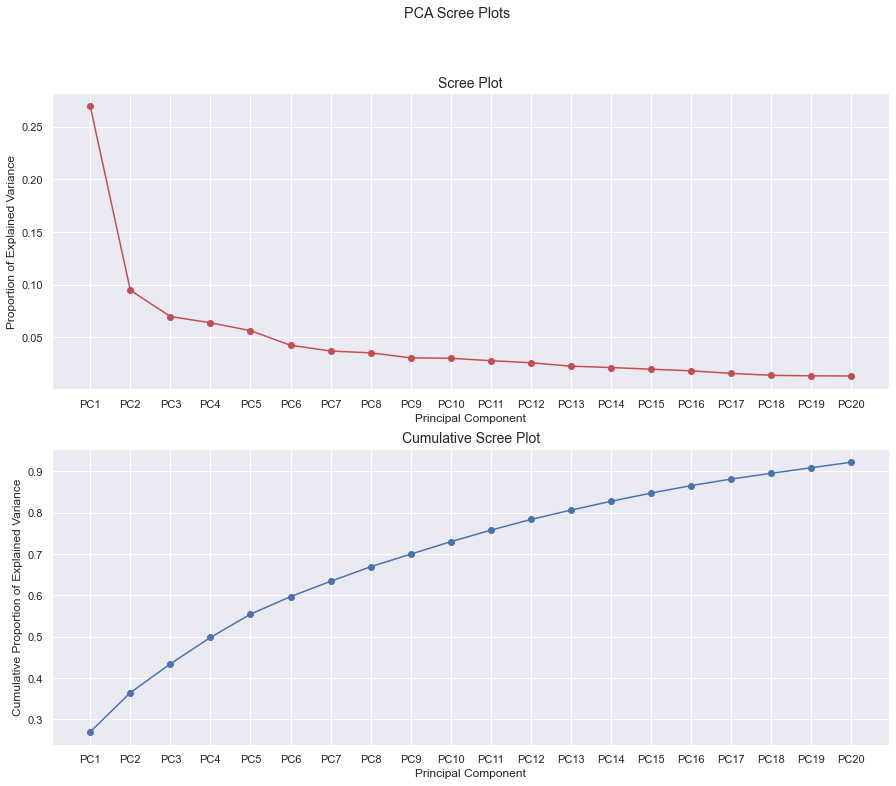

In [101]:
# create scree plot for principal components to decide how many to keep
screefig = plt.figure(figsize=(15,12))
plt.suptitle('PCA Scree Plots')

plt.subplot(2, 1, 1)
plt.plot(pca_df.columns, pca.explained_variance_ratio_, 'ro-')
plt.title('Scree Plot', fontdict={'size': 14})
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

plt.subplot(2, 1, 2)
plt.plot(pca_df.columns, np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.title('Cumulative Scree Plot', fontdict={'size': 14})
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Explained Variance')

In [105]:
# based on these plots, it is best to keep the first 10 principal components, so the explained variance is > 70%
# pca loadings are the coefficients for the principal components
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{n}' for n in np.arange(1, 11)], index=features.columns)